<a href="https://colab.research.google.com/github/shaysakazi/Explainable-Autoencoder/blob/main/Explainable_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle setting

In [1]:
!mkdir /root/.kaggle/

In [2]:
import json
import os

# Installing the Kaggle package
!pip install kaggle 

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"","key":""}

# creating kaggle.json file with the personal API-Key details 
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
# Creating a dataset directory
!mkdir ./datasets/creditcardfraud

# download the dataset from Kaggle and unzip it
!kaggle datasets download mlg-ulb/creditcardfraud -p ./datasets/creditcardfraud/
!unzip ./datasets/creditcardfraud/creditcardfraud.zip -d ./datasets/creditcardfraud/
!rm -r ./datasets/creditcardfraud/creditcardfraud.zip

mkdir: cannot create directory ‘./datasets/creditcardfraud’: No such file or directory
 89% 59.0M/66.0M [00:00<00:00, 46.1MB/s]
100% 66.0M/66.0M [00:00<00:00, 84.8MB/s]
Archive:  ./datasets/creditcardfraud/creditcardfraud.zip
  inflating: ./datasets/creditcardfraud/creditcard.csv  


# Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import Sequential
from keras import backend as K
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from collections import defaultdict

# Loading the dataset

In [5]:
credit_fraud_df = pd.read_csv('./datasets/creditcardfraud/creditcard.csv')

In [6]:
credit_fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Preprocessing

In [7]:
credit_fraud_df[credit_fraud_df.columns] = MinMaxScaler().fit_transform(credit_fraud_df)
credit_fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,0.252484,0.680908,0.371591,0.635591,0.446084,0.434392,0.737173,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0.0
1,0.000000,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,0.381188,0.744342,0.486190,0.641219,0.383840,0.464105,0.727794,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0.0
2,0.000006,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,0.322422,0.706683,0.503854,0.640473,0.511697,0.357443,0.763381,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0.0
3,0.000006,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,0.271817,0.710910,0.487635,0.636372,0.289124,0.415653,0.711253,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0.0
4,0.000012,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,0.236355,0.724477,0.552509,0.608406,0.349419,0.434995,0.724243,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0.0


In [8]:
train, test = train_test_split(credit_fraud_df, test_size=0.2, stratify=credit_fraud_df['Class'])
train, val = train_test_split(train, test_size=0.25, stratify=train['Class'])

X_train, y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
X_test, y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [9]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(170883, 30)
(56962, 30)
(56962, 30)


In [10]:
print(y_train.value_counts())
print(y_val.value_counts())
print(y_test.value_counts())

0.0    170588
1.0       295
Name: Class, dtype: int64
0.0    56863
1.0       99
Name: Class, dtype: int64
0.0    56864
1.0       98
Name: Class, dtype: int64


# Training an autoencoder

In [11]:
def rmse(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred-y_true)))

In [12]:
autoencoder = Sequential()
autoencoder.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
autoencoder.add(Dense(8, activation='sigmoid', name='latent'))
autoencoder.add(Dense(16, activation='relu'))
autoencoder.add(Dense(X_train.shape[1], activation='sigmoid'))
autoencoder.compile(loss=rmse, optimizer='adadelta')
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                496       
_________________________________________________________________
latent (Dense)               (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                510       
Total params: 1,286
Trainable params: 1,286
Non-trainable params: 0
_________________________________________________________________


In [13]:
callbacks_list = [keras.callbacks.ModelCheckpoint('best_model.hdf5' , monitor='val_loss' , verbose=1 , mode='min', save_best_only=True),
                  keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [14]:
history = autoencoder.fit(X_train, X_train, validation_data=(X_val, X_val), epochs=10, verbose=1, callbacks=callbacks_list)

Epoch 1/10
5341/5341 [==============================] - 15s 3ms/step - loss: 0.2291 - val_loss: 0.2164

Epoch 00001: val_loss improved from inf to 0.21636, saving model to best_model.hdf5
Epoch 2/10
5341/5341 [==============================] - 13s 2ms/step - loss: 0.2121 - val_loss: 0.1997

Epoch 00002: val_loss improved from 0.21636 to 0.19974, saving model to best_model.hdf5
Epoch 3/10
5341/5341 [==============================] - 13s 2ms/step - loss: 0.1954 - val_loss: 0.1813

Epoch 00003: val_loss improved from 0.19974 to 0.18133, saving model to best_model.hdf5
Epoch 4/10
5341/5341 [==============================] - 13s 2ms/step - loss: 0.1759 - val_loss: 0.1576

Epoch 00004: val_loss improved from 0.18133 to 0.15755, saving model to best_model.hdf5
Epoch 5/10
5341/5341 [==============================] - 13s 2ms/step - loss: 0.1505 - val_loss: 0.1278

Epoch 00005: val_loss improved from 0.15755 to 0.12778, saving model to best_model.hdf5
Epoch 6/10
5341/5341 [======================

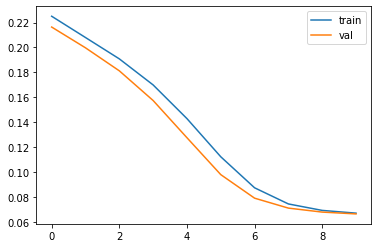

In [15]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

# Predict outliers

In [16]:
X_train_pred = autoencoder.predict(X_train)
autoencoder_total_rmse = np.mean(np.sqrt(np.square(X_train-X_train_pred)), axis=1)
train_error_df = pd.DataFrame({'event_index': X_train.index, 'reconstruction_error': autoencoder_total_rmse, 'true_label': y_train.astype(int)})
threshold = np.percentile(autoencoder_total_rmse, 99.99)
train_error_df['outlier'] = train_error_df['reconstruction_error'].apply(lambda x: 1 if x>threshold else 0)
train_error_df = train_error_df.sort_values('reconstruction_error', ascending=False).reset_index(drop=True)
train_error_df.head(10)

,event_index,reconstruction_error,true_label,outlier
0,274771,0.451317,0,1
1,151296,0.250901,0,1
2,39769,0.233302,0,1
3,154684,0.225215,1,1
4,220212,0.215504,0,1
5,154371,0.211124,1,1
6,10690,0.188667,1,1
7,8296,0.184069,1,1
8,151007,0.182178,1,1
9,151008,0.182178,1,1


In [80]:
train_error_df[train_error_df['true_label']==1].tail(200)

,event_index,reconstruction_error,true_label,outlier
214,6774,0.099364,1,0
221,263274,0.098711,1,0
226,42009,0.097799,1,0
231,250761,0.097278,1,0
235,251477,0.096500,1,0
...,...,...,...,...
124513,192687,0.031334,1,0
125808,219025,0.031190,1,0
129570,204079,0.030769,1,0
152266,72757,0.027513,1,0


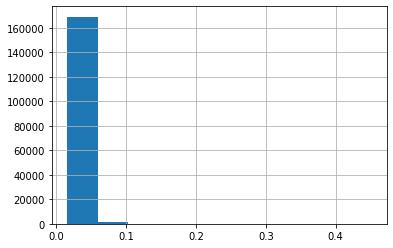

In [17]:
train_error_df['reconstruction_error'].hist(bins=10)

In [18]:
def plot_auc_curve(y_score, y_true):  
  print(f'ROC AUC: {roc_auc_score(y_true, y_score)}')
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  plt.plot(fpr,tpr)
  plt.xlabel('FPR')
  plt.ylabel('TPR')
  plt.show()

ROC AUC: 0.8880666022883563


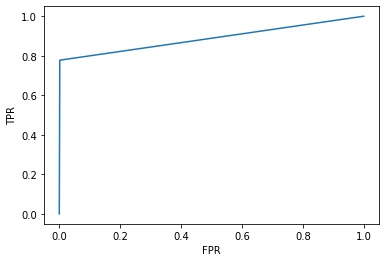

In [19]:
plot_auc_curve(train_error_df['true_label'], train_error_df['outlier'])

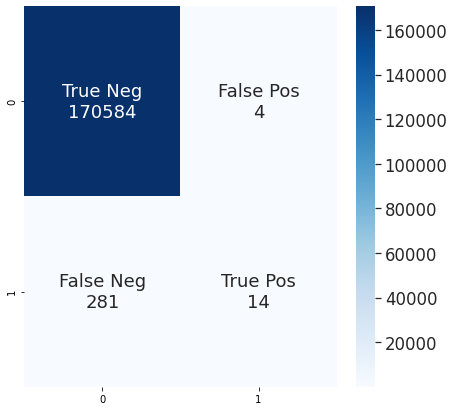

In [20]:
cm = confusion_matrix(train_error_df['true_label'], train_error_df['outlier'])
group_names = ['True Neg', 'False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2,2)
fig, ax = plt.subplots(figsize=(7,7))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', ax=ax);

# Explain predicted outliers features

In [34]:
def get_high_error_features(X_true, X_pred):
  features = defaultdict(int)
  num_of_features = X_true.shape[1]
  for i in range(num_of_features):
    features[i] = np.abs(X_true[0][i] - X_pred[0][i])
  return sorted(features.items(), key=lambda x: x[1], reverse=True)

## TP (index-154371) 

In [62]:
X_154371_true = np.array(X_train.loc[154371]).reshape(1, 30)
X_154371_pred = autoencoder.predict(X_154371_true)

In [63]:
X_154371_true

array([[5.86329228e-01, 5.19542304e-01, 9.69501060e-01, 3.97437120e-01,
        7.45111358e-01, 6.53409275e-01, 3.02569480e-01, 3.95800142e-02,
        4.76883146e-01, 7.94873386e-02, 2.81380503e-02, 5.10421810e-01,
        3.07597912e-01, 2.42622654e-01, 5.18526028e-01, 0.00000000e+00,
        2.40801068e-01, 3.57259363e-01, 2.54071693e-01, 4.65351811e-01,
        6.64459246e-01, 2.88689931e-01, 7.76107775e-01, 7.17560423e-01,
        3.89555122e-01, 5.40186442e-01, 3.91238128e-01, 3.25144843e-01,
        3.04024190e-01, 8.87464793e-05]])

In [64]:
X_154371_pred

array([[0.5252579 , 0.89505124, 0.7703591 , 0.8252092 , 0.26188695,
        0.7614635 , 0.26451874, 0.2723687 , 0.78766304, 0.45104393,
        0.5146408 , 0.27810162, 0.6932663 , 0.44422075, 0.6388999 ,
        0.33309236, 0.44673398, 0.7211296 , 0.64449334, 0.53788507,
        0.5793959 , 0.5534413 , 0.5124751 , 0.66546416, 0.39893842,
        0.5858083 , 0.4370407 , 0.4151931 , 0.3060146 , 0.07514784]],
      dtype=float32)

In [65]:
get_high_error_features(X_154371_true, X_154371_pred)

[(10, 0.4865027577702196),
 (4, 0.48322440344133777),
 (3, 0.4277720805562066),
 (18, 0.39042164806470925),
 (12, 0.3856683607041463),
 (1, 0.375508937232058),
 (9, 0.37155659500386934),
 (17, 0.3638702330525232),
 (15, 0.3330923616886139),
 (8, 0.31077989636614717),
 (21, 0.2647513552684799),
 (22, 0.26363270149662343),
 (7, 0.23278868515358858),
 (11, 0.23232018722035164),
 (16, 0.20593291301357544),
 (13, 0.2015980979651007),
 (2, 0.199141960928656),
 (14, 0.12037389475321303),
 (5, 0.10805424826040644),
 (27, 0.09004826757734435),
 (20, 0.08506335618848937),
 (29, 0.07505909837168324),
 (19, 0.07253325872610156),
 (0, 0.06107134274892434),
 (23, 0.052096260119197324),
 (26, 0.04580255885078688),
 (25, 0.04562183546632448),
 (6, 0.0380507418443875),
 (24, 0.009383295181831341),
 (28, 0.001990407043420017)]

In [66]:
credit_fraud_df.columns[10]

'V10'

## FP (index-274771) 

In [67]:
X_274771_true = np.array(X_train.loc[274771]).reshape(1, 30)
X_274771_pred = autoencoder.predict(X_274771_true)

In [68]:
X_274771_true

array([[0.96183851, 0.35436809, 0.4311887 , 0.        , 0.9303518 ,
        0.        , 1.        , 1.        , 0.49203418, 0.32938171,
        0.26033294, 0.69285813, 0.3578418 , 1.        , 0.4175497 ,
        1.        , 1.        , 0.52268782, 0.51793655, 0.99295426,
        0.        , 0.21295464, 0.77650985, 0.64195294, 1.        ,
        0.83357237, 0.98338597, 1.        , 0.        , 1.        ]])

In [69]:
X_274771_pred

array([[0.5295007 , 0.88470924, 0.7643347 , 0.8115151 , 0.2714771 ,
        0.7500017 , 0.27473706, 0.2785047 , 0.7770372 , 0.46379426,
        0.5094443 , 0.29098547, 0.69222957, 0.44377327, 0.6301904 ,
        0.3332397 , 0.4568252 , 0.71153456, 0.6433843 , 0.5466691 ,
        0.5740016 , 0.561732  , 0.5044287 , 0.65677905, 0.40656182,
        0.5743333 , 0.42506903, 0.4251289 , 0.32004532, 0.08322976]],
      dtype=float32)

In [70]:
get_high_error_features(X_274771_true, X_274771_pred)

[(29, 0.9167702421545982),
 (3, 0.8115150928497314),
 (5, 0.7500017285346985),
 (6, 0.725262939929962),
 (7, 0.7214953005313873),
 (15, 0.6667602956295013),
 (4, 0.658874693759159),
 (24, 0.5934381783008575),
 (27, 0.5748710930347443),
 (20, 0.5740016102790833),
 (26, 0.558316935639928),
 (13, 0.5562267303466797),
 (16, 0.5431748032569885),
 (1, 0.5303411469963091),
 (19, 0.4462851346110487),
 (0, 0.43233778815704604),
 (11, 0.40187266294312063),
 (21, 0.34877735118830594),
 (12, 0.3343877714024176),
 (2, 0.33314597976721066),
 (28, 0.3200453221797943),
 (8, 0.2850030218953563),
 (22, 0.27208116797297277),
 (25, 0.25923905622543086),
 (10, 0.24911135822746544),
 (14, 0.21264066970935064),
 (17, 0.1888467438815038),
 (9, 0.1344125491310897),
 (18, 0.12544772376945557),
 (23, 0.014826107421224699)]

In [71]:
credit_fraud_df.columns[29]

'Amount'

## TN (index-147323) 

In [73]:
X_147323_true = np.array(X_train.loc[147323]).reshape(1, 30)
X_147323_pred = autoencoder.predict(X_147323_true)

In [74]:
X_147323_true

array([[0.51155725, 0.94255643, 0.77516299, 0.8336951 , 0.23791796,
        0.7671407 , 0.24793466, 0.26907825, 0.7884525 , 0.46699454,
        0.47368353, 0.26489858, 0.71837867, 0.44259944, 0.60306803,
        0.29616623, 0.44806495, 0.77036932, 0.64978629, 0.53481077,
        0.58165565, 0.55948081, 0.49037799, 0.6659177 , 0.41958079,
        0.5912385 , 0.41059587, 0.41840719, 0.31201969, 0.00233543]])

In [75]:
X_147323_pred

array([[0.53091043, 0.899516  , 0.7820378 , 0.8279494 , 0.25692096,
        0.7670328 , 0.25797483, 0.26327482, 0.79471487, 0.4557901 ,
        0.5064368 , 0.2755472 , 0.7041467 , 0.440012  , 0.6397084 ,
        0.32439604, 0.44747758, 0.72383875, 0.65403855, 0.5462729 ,
        0.58169734, 0.56322294, 0.5052651 , 0.6726266 , 0.40046498,
        0.5808679 , 0.4239749 , 0.41775766, 0.30386975, 0.06929707]],
      dtype=float32)

In [76]:
get_high_error_features(X_147323_true, X_147323_pred)

[(29, 0.06696163415434828),
 (17, 0.04653057368198443),
 (1, 0.04304044469965129),
 (14, 0.036640370270067835),
 (10, 0.032753297846659646),
 (15, 0.02822981421217452),
 (0, 0.019353184317972838),
 (24, 0.019115810778800812),
 (4, 0.01900300839425184),
 (22, 0.014887121707471973),
 (12, 0.01423198688046401),
 (26, 0.013379032286591375),
 (19, 0.011462101081738174),
 (9, 0.011204435238910238),
 (11, 0.010648630557161642),
 (25, 0.010370614415310286),
 (6, 0.01004017275094507),
 (28, 0.00814993356830468),
 (2, 0.006874807703477592),
 (23, 0.006708914458704585),
 (8, 0.006262364410749677),
 (7, 0.005803434051862566),
 (3, 0.005745690426643746),
 (18, 0.004252254846632941),
 (21, 0.003742134065392144),
 (13, 0.002587435234468749),
 (27, 0.0006495280679996163),
 (16, 0.0005873685813838625),
 (5, 0.00010789404056998908),
 (20, 4.169716783997135e-05)]

In [77]:
credit_fraud_df.columns[29]

'Amount'

## FN (index-118308) 

In [85]:
X_118308_true = np.array(X_train.loc[118308]).reshape(1, 30)
X_118308_pred = autoencoder.predict(X_118308_true)

In [86]:
X_118308_true

array([[3.17410528e-01, 9.07557425e-01, 7.67248964e-01, 8.47912783e-01,
        2.66928427e-01, 7.70330716e-01, 2.47114667e-01, 2.68427196e-01,
        7.82881802e-01, 4.84715441e-01, 5.29624529e-01, 2.85554295e-01,
        7.05865971e-01, 4.80907786e-01, 6.14728993e-01, 4.22146281e-01,
        4.64714053e-01, 7.26699556e-01, 6.33644898e-01, 5.68980354e-01,
        5.72127694e-01, 5.47371796e-01, 4.86246565e-01, 6.84946425e-01,
        4.30078956e-01, 6.03084885e-01, 4.57054523e-01, 4.38929470e-01,
        3.12841326e-01, 6.96737711e-05]])

In [87]:
X_118308_pred

array([[0.5301922 , 0.8988292 , 0.78097254, 0.827202  , 0.25762257,
        0.7667646 , 0.25879952, 0.2641847 , 0.794159  , 0.45548782,
        0.50638086, 0.27665585, 0.7031961 , 0.4408358 , 0.6397528 ,
        0.32524112, 0.44793233, 0.7236782 , 0.6537957 , 0.5459011 ,
        0.5811544 , 0.5632025 , 0.5058439 , 0.6723047 , 0.40086734,
        0.58093065, 0.42480013, 0.417474  , 0.30468702, 0.07003584]],
      dtype=float32)

In [88]:
get_high_error_features(X_118308_true, X_118308_pred)

[(0, 0.21278166810397364),
 (15, 0.09690516208008576),
 (29, 0.06996616381963855),
 (13, 0.04007198196396383),
 (26, 0.03225439556051546),
 (9, 0.029227623215711818),
 (24, 0.029211613024024752),
 (14, 0.025023811866039414),
 (10, 0.023243673234791262),
 (19, 0.023079234766715917),
 (25, 0.02215423497154967),
 (27, 0.021455468038986958),
 (3, 0.020710760817630125),
 (18, 0.020150821000384456),
 (22, 0.01959731321668301),
 (16, 0.016781720196155425),
 (21, 0.015830703934959223),
 (2, 0.013723576609255606),
 (23, 0.012641735405084842),
 (6, 0.011684856133213267),
 (8, 0.011277192952027226),
 (4, 0.009305856875130636),
 (20, 0.009026711660617637),
 (11, 0.008898442175550858),
 (1, 0.008728203105594967),
 (28, 0.00815430321525823),
 (7, 0.004242482643528167),
 (5, 0.003566135271451887),
 (17, 0.003021384150941331),
 (12, 0.002669862938530776)]

In [89]:
credit_fraud_df.columns[0]

'Time'